
[Real Data Only] Training size: 20
KNN Accuracy (Real Data) for size 20: 0.8460
Training Conditional GAN on the same subset...
[GAN Epoch 1/20] D loss: 0.6921, G loss: 0.6623
[GAN Epoch 2/20] D loss: 0.6420, G loss: 0.6497
[GAN Epoch 3/20] D loss: 0.6003, G loss: 0.6364


/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 4/20] D loss: 0.5641, G loss: 0.6193
[GAN Epoch 5/20] D loss: 0.5337, G loss: 0.6000
[GAN Epoch 6/20] D loss: 0.5122, G loss: 0.5817
[GAN Epoch 7/20] D loss: 0.4939, G loss: 0.5775
[GAN Epoch 8/20] D loss: 0.4692, G loss: 0.6028
[GAN Epoch 9/20] D loss: 0.4407, G loss: 0.6568
[GAN Epoch 10/20] D loss: 0.4144, G loss: 0.7365
[GAN Epoch 11/20] D loss: 0.4049, G loss: 0.8087
[GAN Epoch 12/20] D loss: 0.4274, G loss: 0.7907
[GAN Epoch 13/20] D loss: 0.4731, G loss: 0.7478
[GAN Epoch 14/20] D loss: 0.5186, G loss: 0.7147
[GAN Epoch 15/20] D loss: 0.5344, G loss: 0.6900
[GAN Epoch 16/20] D loss: 0.4852, G loss: 0.7767
[GAN Epoch 17/20] D loss: 0.4078, G loss: 0.8911
[GAN Epoch 18/20] D loss: 0.3284, G loss: 1.0324
[GAN Epoch 19/20] D loss: 0.2764, G loss: 1.1528
[GAN Epoch 20/20] D loss: 0.2318, G loss: 1.2982
KNN Accuracy (After Concatenation) for size 20: 0.8841

[Real Data Only] Training size: 50
KNN Accuracy (Real Data) for size 50: 0.8598
Training Conditional GAN on the same 

/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 18/20] D loss: 0.1017, G loss: 2.4221
[GAN Epoch 19/20] D loss: 0.3371, G loss: 2.4086
[GAN Epoch 20/20] D loss: 0.1477, G loss: 1.7269
KNN Accuracy (After Concatenation) for size 50: 0.8943

[Real Data Only] Training size: 100
KNN Accuracy (Real Data) for size 100: 0.8425
Training Conditional GAN on the same subset...
[GAN Epoch 1/20] D loss: 0.6185, G loss: 0.6492
[GAN Epoch 2/20] D loss: 0.4915, G loss: 0.6055
[GAN Epoch 3/20] D loss: 0.4398, G loss: 0.7230
[GAN Epoch 4/20] D loss: 0.5439, G loss: 0.7026


/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 5/20] D loss: 0.3292, G loss: 1.0382
[GAN Epoch 6/20] D loss: 0.2461, G loss: 1.2611
[GAN Epoch 7/20] D loss: 0.1886, G loss: 1.5283
[GAN Epoch 8/20] D loss: 0.2365, G loss: 1.7386
[GAN Epoch 9/20] D loss: 0.2938, G loss: 2.8028
[GAN Epoch 10/20] D loss: 0.2259, G loss: 2.1755
[GAN Epoch 11/20] D loss: 0.1810, G loss: 1.9499
[GAN Epoch 12/20] D loss: 0.1000, G loss: 2.8340
[GAN Epoch 13/20] D loss: 0.1001, G loss: 2.4789
[GAN Epoch 14/20] D loss: 0.1340, G loss: 3.0154
[GAN Epoch 15/20] D loss: 0.0636, G loss: 3.1176
[GAN Epoch 16/20] D loss: 0.0705, G loss: 2.7732
[GAN Epoch 17/20] D loss: 0.2675, G loss: 2.8405
[GAN Epoch 18/20] D loss: 0.5806, G loss: 5.0166
[GAN Epoch 19/20] D loss: 0.2144, G loss: 3.8349
[GAN Epoch 20/20] D loss: 0.4868, G loss: 2.4267
KNN Accuracy (After Concatenation) for size 100: 0.8913

[Real Data Only] Training size: 200
KNN Accuracy (Real Data) for size 200: 0.8557
Training Conditional GAN on the same subset...
[GAN Epoch 1/20] D loss: 0.5799, G 

/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/20] D loss: 0.4388, G loss: 0.7721
[GAN Epoch 3/20] D loss: 0.3956, G loss: 0.9116
[GAN Epoch 4/20] D loss: 0.2192, G loss: 1.3857
[GAN Epoch 5/20] D loss: 0.2130, G loss: 2.0058
[GAN Epoch 6/20] D loss: 0.2437, G loss: 2.3221
[GAN Epoch 7/20] D loss: 0.1331, G loss: 3.5543
[GAN Epoch 8/20] D loss: 0.1044, G loss: 2.6019
[GAN Epoch 9/20] D loss: 0.0771, G loss: 3.1893
[GAN Epoch 10/20] D loss: 0.0714, G loss: 2.8795
[GAN Epoch 11/20] D loss: 0.3193, G loss: 3.4986
[GAN Epoch 12/20] D loss: 0.4565, G loss: 3.0872
[GAN Epoch 13/20] D loss: 0.4515, G loss: 1.6556
[GAN Epoch 14/20] D loss: 0.2695, G loss: 1.7103
[GAN Epoch 15/20] D loss: 0.1924, G loss: 2.1670
[GAN Epoch 16/20] D loss: 0.1859, G loss: 2.5992
[GAN Epoch 17/20] D loss: 0.2330, G loss: 2.9883
[GAN Epoch 18/20] D loss: 0.3903, G loss: 3.2244
[GAN Epoch 19/20] D loss: 0.2560, G loss: 2.5130
[GAN Epoch 20/20] D loss: 0.3507, G loss: 2.5431
KNN Accuracy (After Concatenation) for size 200: 0.8923

[Real Data Only] Tra

/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/20] D loss: 0.1135, G loss: 2.8251
[GAN Epoch 3/20] D loss: 0.3922, G loss: 2.6904
[GAN Epoch 4/20] D loss: 0.1784, G loss: 3.0294
[GAN Epoch 5/20] D loss: 0.2655, G loss: 3.2685
[GAN Epoch 6/20] D loss: 0.2529, G loss: 2.4590
[GAN Epoch 7/20] D loss: 0.2912, G loss: 3.5556
[GAN Epoch 8/20] D loss: 0.3121, G loss: 2.6091
[GAN Epoch 9/20] D loss: 0.2797, G loss: 2.9257
[GAN Epoch 10/20] D loss: 0.4466, G loss: 2.7141
[GAN Epoch 11/20] D loss: 0.3964, G loss: 2.0849
[GAN Epoch 12/20] D loss: 0.4679, G loss: 2.1855
[GAN Epoch 13/20] D loss: 0.4612, G loss: 2.0155
[GAN Epoch 14/20] D loss: 0.4994, G loss: 1.8224
[GAN Epoch 15/20] D loss: 0.4917, G loss: 1.5900
[GAN Epoch 16/20] D loss: 0.4665, G loss: 1.7036
[GAN Epoch 17/20] D loss: 0.4938, G loss: 1.7572
[GAN Epoch 18/20] D loss: 0.4856, G loss: 1.8596
[GAN Epoch 19/20] D loss: 0.4671, G loss: 1.8261
[GAN Epoch 20/20] D loss: 0.4547, G loss: 1.7669
KNN Accuracy (After Concatenation) for size 1000: 0.9024

[Real Data Only] Tr

/tmp/ipykernel_9645/886932756.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_9645/886932756.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/20] D loss: 0.2899, G loss: 2.6012
[GAN Epoch 2/20] D loss: 0.4026, G loss: 2.3402
[GAN Epoch 3/20] D loss: 0.4049, G loss: 2.0733
[GAN Epoch 4/20] D loss: 0.4557, G loss: 1.7831
[GAN Epoch 5/20] D loss: 0.4722, G loss: 1.5565
[GAN Epoch 6/20] D loss: 0.4836, G loss: 1.4977
[GAN Epoch 7/20] D loss: 0.5092, G loss: 1.3676
[GAN Epoch 8/20] D loss: 0.5256, G loss: 1.2736
[GAN Epoch 9/20] D loss: 0.5295, G loss: 1.2436
[GAN Epoch 10/20] D loss: 0.5541, G loss: 1.1894
[GAN Epoch 11/20] D loss: 0.5589, G loss: 1.1248
[GAN Epoch 12/20] D loss: 0.5816, G loss: 1.0692
[GAN Epoch 13/20] D loss: 0.5821, G loss: 1.0321
[GAN Epoch 14/20] D loss: 0.5935, G loss: 1.0135
[GAN Epoch 15/20] D loss: 0.5918, G loss: 1.0065
[GAN Epoch 16/20] D loss: 0.5921, G loss: 1.0069
[GAN Epoch 17/20] D loss: 0.5988, G loss: 0.9971
[GAN Epoch 18/20] D loss: 0.5913, G loss: 0.9898
[GAN Epoch 19/20] D loss: 0.5936, G loss: 0.9909


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


[GAN Epoch 20/20] D loss: 0.5990, G loss: 0.9994
KNN Accuracy (After Concatenation) for size 7872: 0.9060

Accuracy Summary:
   Train Samples  Real Only Accuracy  After Concatenation Accuracy
0             20            0.846037                      0.884146
1             50            0.859756                      0.894309
2            100            0.842480                      0.891260
3            200            0.855691                      0.892276
4           1000            0.881606                      0.902439
5           7872            0.885671                      0.905996
╒═════════════════╤══════════════════════╤════════════════════════════════╕
│   Train Samples │   Real Only Accuracy │   After Concatenation Accuracy │
╞═════════════════╪══════════════════════╪════════════════════════════════╡
│              20 │             0.846037 │                       0.884146 │
├─────────────────┼──────────────────────┼────────────────────────────────┤
│              50 │       

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


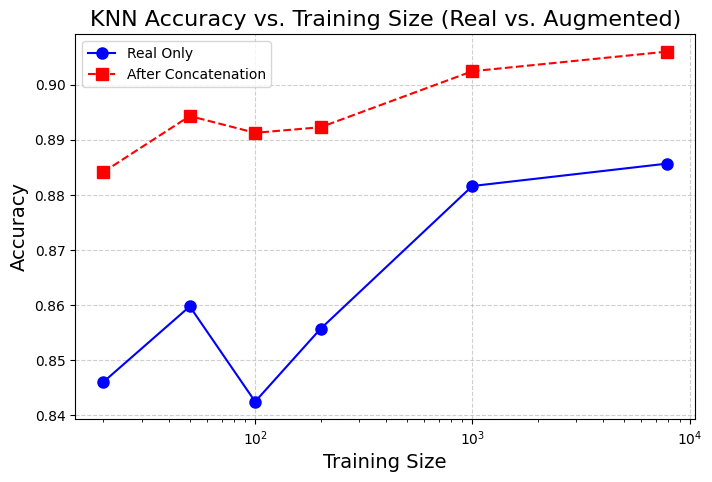

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from datasets import load_from_disk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# ------------------------------------------------
# 1. 全局參數設定
# ------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128          # GAN 雜訊向量維度
condition_dim = 10        # 條件嵌入維度
gan_epochs = 20            # GAN 訓練 epoch
generation_size = 1000    # 每個類別要生成的樣本數
batch_size = 32           # DataLoader 的批次大小
num_epochs_knn = 0        # KNN 無需 epoch, 這裡可忽略
# 如果想要觀察 DNN epoch 類似的流程，可以保留一個數值但實際對KNN無效

# ------------------------------------------------
# 2. 載入已預計算的嵌入資料集
# ------------------------------------------------
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

# 取出測試集 embeddings 與 labels (numpy array)
test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

# 取出完整訓練資料 (embedding + labels)
train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])

# ------------------------------------------------
# 3. 定義 Conditional GAN 模型 (Generator, Discriminator)
# ------------------------------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = latent_dim + condition_dim
        layers = []
        # 第一層
        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim
        # 中間 n_layer-1 層
        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
        # 最後輸出層
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, input_dim=512):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        # input_dim + condition_dim
        input_dim = input_dim + condition_dim
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        current_dim = hidden_dim
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)

# ------------------------------------------------
# 4. 準備 PyTorch Dataset 以便載入 (若需要)
# ------------------------------------------------
# 這裡若只用 train_x_full / train_y_full, 可直接用 numpy -> KNN 不一定要 DataLoader
# 但我們需要 DataLoader 來訓練GAN (batch-wise)

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

test_ds = EmbeddingDataset(test_dataset)
test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)  # 用於GAN測試? 其實KNN不需要

# ------------------------------------------------
# 5. 定義 sample_sizes 與記錄 (Before / After) 的 Accuracy
# ------------------------------------------------
sample_sizes = [20, 50, 100, 200, 1000, len(train_ds)]
knn_accuracy_before = {}
knn_accuracy_after = {}

# ------------------------------------------------
# 6. 主迴圈: 針對不同的訓練資料量做實驗
# ------------------------------------------------
for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    # (A) 取前 size 筆真實資料 (X_train, y_train)
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]

    # (A1) 用 KNN 在「真實資料」上訓練
    from sklearn.neighbors import KNeighborsClassifier
    knn_real = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_real.fit(X_train, y_train)
    pred_before = knn_real.predict(test_x)
    acc_before = accuracy_score(test_y, pred_before)
    print(f"KNN Accuracy (Real Data) for size {size}: {acc_before:.4f}")
    knn_accuracy_before[size] = acc_before

    # -----------------------------
    # (B) 訓練 Conditional GAN 在該子集上
    # -----------------------------
    print("Training Conditional GAN on the same subset...")
    train_subset = Subset(train_ds, range(size))
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)

    input_dim = X_train.shape[1]  # 預設embedding向量維度
    unique_labels = np.unique(train_y_full)
    num_classes_gan = len(unique_labels)

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim
    ).to(device)
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    ).to(device)

    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)

            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")

    # -----------------------------
    # (C) 生成合成資料
    # -----------------------------
    synthetic_data_list = []
    synthetic_labels_list = []
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))

    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)

    # (C1) 將真實資料與合成資料合併
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)

    # (C2) 用 KNN 訓練 (After Concatenation)
    knn_aug = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_aug.fit(train_combined_x, train_combined_y)
    pred_after = knn_aug.predict(test_x)
    acc_after = accuracy_score(test_y, pred_after)
    print(f"KNN Accuracy (After Concatenation) for size {size}: {acc_after:.4f}")
    knn_accuracy_after[size] = acc_after

# ------------------------------------------------
# 7. 輸出結果 (Before vs. After)
# ------------------------------------------------
summary_df = pd.DataFrame(
    [[s, knn_accuracy_before[s], knn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("\nAccuracy Summary:")
print(summary_df)
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

# 繪製圖表
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, [knn_accuracy_before[s] for s in sample_sizes], marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, [knn_accuracy_after[s] for s in sample_sizes], marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("KNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
